# 决策树

决策树模型用一系列树形结构的问题来对实例进行分类，它也可以表示给定特征条件下的类的条件概率分布$P(Y|X)$（见统计学习方法p56）。

**决策树算法特点**  
优点：计算复杂度不高，输出结果易于理解，数据有缺失也能跑，可以处理不相关特征。  
缺点：容易过拟合。  
适用数据类型：数值型和标称型优点：计算复杂度

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] # deal with the Chinese characters
plt.rcParams['axes.unicode_minus'] = False 

import pandas as pd
import networkx as nx
import graphviz

import xgboost as xgb
from sklearn import tree

inf = float('inf')

## 决策树的学习
决策树由结点和有向边构成。对一个样本的分类起始于根结点，在每个内部结点处对某个特定的属性进行判断，并沿着对应属性值的边到达子结点。反复划分直到叶结点处。一个样本以叶结点的标记作为分类的结果。  
决策树学习要从训练数据集中归纳出一组分类规则，它包括三个部分：**特征选择**、**决策树的生成**，以及**决策树的修剪**。

### 决策树的生成
决策树学习的损失函数是正则化的极大似然函数，但由于最大化似然函数是个NP完全问题，所以一般采用下述启发式方法来学习次优的决策树。

```
TreeGenerate(D, A)  //D={(x1, y1), (x2, y2), ..., (xm, ym)}是训练集，A={a1, a2, ..., ad}是属性集
 1  生成结点node
 2  if D中的样本属于同一个类别C:   //同一属性无需划分
 3      将node标记为C类的叶结点
 4      return node
 5  if A==Φ or D中样本在A上取值相同:  //无法划分的情况
 6      将node标为叶结点，它的标记为D中样本数最多的类
 7      return node
 8  从A中选择最优划分的属性a* //由特征选择过程给出
 9  for a*的所有可能值av*:
10     取出值为av*的样本子集Dv
11     if Dv == Φ:
12         新建一个分支结点node2，并标记为叶结点，将其类别设为D中样本最多的类
13     else:
14         以TreeGenerate(Dv, A\{a*})作为分支结点node2
15     用分支条件a*==av*的edge将node和node2相连
16  return node
```

In [2]:
def split_attribute(X, y, attr_axis):
    """
    Parameters
    ------------
    X : numpy array, (m, n)
        features of training examples
    y : numpy array, (m, 1)
        labels of training examples
    attr_axis : integer, [0, n)
        the index of attribute to split
        
    Returns
    ---------
    x_split : numpy array
        the split point of X in attr_axis
    Xs_new : list of numpy array, [(m1, n), (m2, n), ...]
        the freatures of splitted examples
    ys_new : list of numpy array, [(m1, 1), (m2, 1), ...]
        the label of splitted examples
    """
    xs = np.unique(X[:, attr_axis])
    Xs_new, ys_new = [], []
    for x in xs:
        filter_ = (X[:, attr_axis]==x)
        Xs_new.append(X[filter_, :])
        ys_new.append(y[filter_, :])
    return xs, Xs_new, ys_new

def best_discrete_feature(X, y, scorefunc, filter_, seed=None):
    """
    Parameters
    ------------
    X : numpy array, (m, n)
        features of training examples
    y : numpy array, (m, 1)
        labels of training examples
    scorefunc : function, f(y: np.array, ys_new: list) -> float
        the function used to calculate the score of
        each feature
    filter_ : array of bools (n, )
        if the corresponding term of feature in filter_ is
        False, the feature will not be splitted
        *NOTE*: make sure not all False in the array
    seed : int or None
        random seed
        
    Returns
    ---------
    best_index : integer, [0, n)
        the index of highest score feature
    best_score : double
        the score of that feature
    best_xsplit : numpy array
        the split point of X for the highest score feature
    best_Xs_new : list of numpy array, [(m1, n), (m2, n), ...]
        the features of splitted examples
    best_ys_new : list of numpy array, [(m1, 1), (m2, 1), ...]
        the label of splitted examples
    """
    # generate random indices
    n = X.shape[1]
    indices = np.arange(n)[filter_]
    np.random.seed(seed)
    np.random.shuffle(indices)
    
    # find the best feature
    best_score = -inf
    best_index, best_xsplit = None, None
    best_Xs_new, best_ys_new = None, None
    for i in indices:
        xsplit, Xs_new, ys_new = split_attribute(X, y, i)
        score = scorefunc(y, ys_new)
        #print(i, score)
        if score > best_score:
            best_score = score
            best_index = i
            best_xsplit = xsplit
            best_Xs_new = Xs_new
            best_ys_new = ys_new

    # the best feature will not be chosen again
    assert best_index is not None
    filter_[best_index] = False
    return best_index, best_score, best_xsplit, best_Xs_new, best_ys_new

def generate_tree(X, y, scorefunc,
                 maxdepth=None, filter_=None, seed=None,
                 feature_finder=best_discrete_feature):
    """
    The main structure of generate a decision tree:
    1. if same type labels of features, set to be a leaf node
    2. find the best feature to separate, set to be a inner node
    3. separate the training data with the feature, deal
        with each of them recursively
    
    Parameters
    ------------
    X : numpy array, (m, n)
        features of training examples
    y : numpy array, (m, 1)
        labels of training examples
    scorefunc : function, f(y: np.array, ys_new: list) -> float
        the function used to calculate the score of
        each feature
    maxdepth : integer, or None (default)
        the maximum depth of the tree
    filter_ : array of bools (n, ), or None (default)
        if the corresponding term of feature in filter_ is
        False, the feature will not be splitted
    seed : int or None
        random seed
    feature_finder : function
        the algorithm used to find the best feature
        
    Returns
    ---------
    tree : dict
        {cond1 : subtree1, cond2 : subtree2, ...} for tree:
                       root
            cond1 /     \ cond2
                     /         \
           subtree1    subtree2
    """
    #print(X, y, maxdepth, filter_, seed)
    # create a new node
    tree = {}

    m, n = X.shape
    if filter_ is None:
        filter_ = np.array([True]*n, dtype=bool)

    # count the numbers of y
    ycounts = {}
    for yval in y.flat:
        if not yval in ycounts:
            ycounts[yval] = 1
        else:
            ycounts[yval] += 1

    # find the most frequent one
    yfreq = sorted(ycounts.items(), key=lambda t: t[1], reverse=True)[0][0]

    # default case: the most frequent label
    tree[None] = (None, yfreq) # axis, label

    # case 0: all the case with the same label
    if ycounts[yfreq] == m:
        #print('c0')
        return tree
    
    # case 1: reach the maxdepth
    if maxdepth is not None and maxdepth <= 1:
        #print('c1')
        return tree
    
    # case 2: no attribute remains
    if not filter_.any():
        #print('c2')
        return tree
    
    # case 3: all the features are the same
    i = 0
    while i<n and (not filter_[i] or (X[:, i]==X[0, i]).all()):
        i += 1
    if i == n:
        #print('c3')
        return tree

    # find the best feature
    best_index, best_score, best_xsplit, best_Xs_new, best_ys_new = \
        feature_finder(X, y, scorefunc, filter_=filter_, seed=seed)
    
    # recursively generate the trees
    tree[None] = (best_index, yfreq) # axis, label
    for xsplit, X_new, y_new in zip(best_xsplit, best_Xs_new, best_ys_new):
        child = generate_tree(
            X_new, y_new, scorefunc,
            maxdepth=maxdepth if maxdepth is None else maxdepth-1,
            filter_=filter_.copy(), seed=seed if seed is None else seed+1,
            feature_finder=feature_finder
        )
        tree[xsplit] = child
    return tree

def classify_one(x, tree):
    """
    Parameters
    -------------
    x : numpy array, (n, )
        a feature vector for a particular sample
    tree : dict
        the trained tree
        
    Returns
    ---------
    y : object
        the label of the input sample
    """
    cur = tree
    while cur[None][0] is not None:
        xval = x[cur[None][0]]
        if xval in cur:
            cur = cur[xval]
        else:
            break
    return cur[None][1]

def classify(X, tree):
    """
    Parameters
    -------------
    X : numpy array, (m, n)
        a feature vector for samples
    tree : dict
        the trained tree
        
    Returns
    ---------
    y : numpy array, (m, 1)
        the label of the input samples
    """
    if X.ndim == 1:
        X = X.reshape(1, -1)
    m = X.shape[0]
    y = []
    for i in range(m):
        x = X[i, :]
        y.append(classify_one(x, tree))
    return np.array(y).reshape(-1, 1)

In [3]:
from collections import deque

def tree_visualize(tree, colnames=None, figsize=(17, 8)):
    """
    Parameters
    -------------
    tree : dict
        the generated decision tree
    colnames : list, or None (default)
        the label of the column
        
    Returns
    --------
    fg : matplotlib.figure.Figure
        the figure of the decision tree
    """
    g = nx.Graph()

    node_labels, edge_labels = {}, {}
    next_index = 0
    def dfs(subtree, parent_index=None):
        nonlocal node_labels, edge_labels, next_index

        this_index = next_index
        g.add_node(this_index)
        if parent_index is not None:
            g.add_edge(parent_index, this_index)

        misc = subtree[None]
        node_labels[this_index] = misc[1]
        next_index += 1
        
        for key, dict_ in subtree.items():
            if key is None: continue
            if colnames is None:
                edge_labels[(this_index, next_index)] = 'A[{}] is {}'.format(misc[0], key)
            else:
                edge_labels[(this_index, next_index)] = '{} is {}'.format(colnames[misc[0]], key)
            dfs(dict_, this_index)
    
    dfs(tree)

    fg, ax = plt.subplots(figsize=figsize)
    pos = nx.drawing.nx_agraph.graphviz_layout(g, prog='dot')
    nx.draw_networkx(g, pos, ax=ax, arrows=True, node_color='0.7', node_size=400,
        with_labels=True, labels=node_labels, font_size=14, font_color='k'
        )
    nx.draw_networkx_edge_labels(g, pos, ax=ax, edge_labels=edge_labels, font_size=11)
    
    ax.axis('off')
    return fg

### 特征选择
定性的讲，如果一个特征使得其分支结点的样本类型的纯净度越高，则该特征越优秀。我们有几种方式来定量地描述样本的纯净度：**信息增益**、**增益率**、**Gini系数**。
不同的选择方式对应了不同的决策树算法：  
`ID3`算法：信息增益，倾向于值较多的属性；
`C4.5`算法：增益率，倾向于值较少的属性；
`CART`算法：Gini系数。

#### 信息增益与信息增益率
**熵**：描述随机变量的随机性，$H(X) = -\sum_k p_k \log_2 p_k$，其中$p_i = P(X=x_i)$。随机变量分布的不确定性越大，熵越大。
当表示一组样本的类型不确定性时，我们用$Y$的经验分布$p_k=P(Y=y_k)=\frac{n_k}{N}$来代替其真实的概率分布，即$H(D)=-\sum_{k=1}^{|{\mathcal Y}|} \frac{n_k}{N} \log_2 \left (\frac{n_k}{N} \right)$。

**条件熵**：描述已知随机变量$X$的条件下随机变量$Y$的不确定性：$H(Y|X) = \sum_k P(X=x_k) H(Y| X=x_k)$。
对于一组样本而言，$H(D|A) = \sum_k \frac{n_k}{N} H(D_k)$。

**信息增益**：描述得知特征$X$后使$Y$的信息不确定减少的程度：$Gain(D,A)=H(D)-H(D|A)$。

**信息增益率**：$GainRatio(D, A)= Gain(D, A)/H_A(D)$，其中$H_A(D)=-\sum_v \frac{|D_v|}{|D|} \ln \frac{|D_v|}{|D|}$称为属性的**固有值**（intrinsic value），属性A的可能值越多，$H_A$越大，$GainRatio$越小。

#### 基尼系数
**Gini系数**：数据集中抽出两个样本，其类别标记不一致的概率，即$Gini(D)=\sum_k p_k (1-p_k)=1-\sum_k p_k^2$。显然，样本纯净度高，不一致的概率就越低，基尼系数就越小。

属性A的Gini系数：$Gini(D, A) = \sum_v \frac{|D_v|}{|D|} Gini(D_v)$。

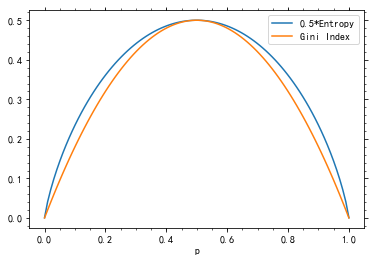

In [4]:
# 二分类情况下的熵和Gini系数
fg0, ax0 = plt.subplots()

p = np.linspace(0.0001, 0.9999, 100)
ax0.plot(p, 0.5*(-p*np.log2(p)-(1.-p)*np.log2(1.-p)), label='0.5*Entropy')
ax0.plot(p, p*(1.-p) + (1.-p)*p, label='Gini Index')
ax0.set_xlabel('p')
ax0.legend()

In [5]:
def gain(y_before, ys_after):
    """
    maximize it to find the best split
    
    Parameters
    ------------
    y_before : numpy array, (m, 1)
        the labels before splitted
    ys_after : list of numpy array, [(m1, 1), (m2, 1), ...], , m1+m2+...=m
        the list of labels splitted
    
    Returns
    ---------
    gain : scalar
        information gain
    """
    m = y_before.shape[0]
    #ys = set(y_before[:, 0].tolist())
    ys = np.unique(y_before)

    H0 = 0.
    for yval in ys:
        py = (y_before==yval).sum()/m
        H0 += -py*np.log2(py)

    H1 = 0.
    for y in ys_after:
        mx = y.shape[0]
        px = mx/m
        eps = 1./mx
        for yval in ys:
            pyx = (y==yval).sum()/mx
            if pyx < eps: continue
            H1 += px*(-pyx*np.log2(pyx))
            
    return H0-H1

def gain_ratio(y_before, ys_after):
    """
    maximize it to find the best split
    
    Parameters
    ------------
    y_before : numpy array, (m, 1)
        the labels before splitted
    ys_after : list of numpy array, [(m1, 1), (m2, 1), ...], , m1+m2+...=m
        the list of labels splitted
    
    Returns
    ---------
    gain_ratio : scalar
        information gain ratio
    """
    m = y_before.shape[0]
    #ys = set(y_before[:, 0].tolist())
    ys = np.unique(y_before)
    
    H0 = 0.
    for yval in ys:
        py = (y_before==yval).sum()/m
        H0 += -py*np.log2(py)

    H1, IV = 0., 0.
    for y in ys_after:
        mx = y.shape[0]
        px = mx/m
        if mx < 1: continue
        IV += -px*np.log2(px)
        eps = 1./mx
        for yval in ys:
            pyx = (y==yval).sum()/mx
            if pyx < eps: continue
            H1 += px*(-pyx*np.log2(pyx))

    if IV < 1e-7: IV = 1e-7
    return (H0-H1)/IV
    
def neg_gini_index(y_before, ys_after):
    """
    maximize it to find the best split
    
    Parameters
    ------------
    y_before : numpy array, (m, 1)
        the labels before splitted
    ys_after : list of numpy array, [(m1, 1), (m2, 1), ...], m1+m2+...=m
        the list of labels splitted
    
    Returns
    ---------
    neg_gini_index : scalar
        negative Gini index
    """
    m = y_before.shape[0]
    #ys = set(y_before[:, 0].tolist())
    ys = np.unique(y_before)
    
    G = 0.
    for y in ys_after:
        mx = y.shape[0]
        if mx < 1: continue
        px = mx/m
        for yval in ys:
            py = (y==yval).sum()/mx
            G += px*(1.-py**2)
    return -G

**一个例子**

In [6]:
#!cat datasets/wm3.dat

In [7]:
raw = pd.read_table('datasets/wm3.dat', delimiter='\s+', index_col=0)
raw

,色泽,根蒂,敲声,纹理,脐部,触感,密度,含糖率,好瓜
#编号,,,,,,,,,
1,青绿,蜷缩,浊响,清晰,凹陷,硬滑,0.679,0.460,是
2,乌黑,蜷缩,沉闷,清晰,凹陷,硬滑,0.774,0.376,是
3,乌黑,蜷缩,浊响,清晰,凹陷,硬滑,0.634,0.264,是
4,青绿,蜷缩,沉闷,清晰,凹陷,硬滑,0.608,0.318,是
5,浅白,蜷缩,浊响,清晰,凹陷,硬滑,0.556,0.215,是
6,青绿,稍蜷,浊响,清晰,稍凹,软粘,0.403,0.237,是
7,乌黑,稍蜷,浊响,稍糊,稍凹,软粘,0.481,0.149,是
8,乌黑,稍蜷,浊响,清晰,稍凹,硬滑,0.437,0.211,是
9,乌黑,稍蜷,沉闷,稍糊,稍凹,硬滑,0.666,0.091,否


In [8]:
X, y = raw.iloc[:, :-3].values, raw.iloc[:, -1:].values
colnames = raw.columns[:-3]

In [9]:
_, Xs_new, ys_new = split_attribute(X, y, 5)
print('gain={}, gain_ratio={}, Gini_index={}'.format(gain(y, ys_new), gain_ratio(y, ys_new), -neg_gini_index(y, ys_new)))

gain=0.006046489176565695, gain_ratio=0.006918329853400427, Gini_index=1.4941176470588236


{None: (3, '否'),
 '模糊': {None: (None, '否')},
 '清晰': {None: (1, '是'),
  '硬挺': {None: (None, '否')},
  '稍蜷': {None: (0, '是'),
   '乌黑': {None: (5, '是'),
    '硬滑': {None: (None, '是')},
    '软粘': {None: (None, '否')}},
   '青绿': {None: (None, '是')}},
  '蜷缩': {None: (None, '是')}},
 '稍糊': {None: (5, '否'), '硬滑': {None: (None, '否')}, '软粘': {None: (None, '是')}}}

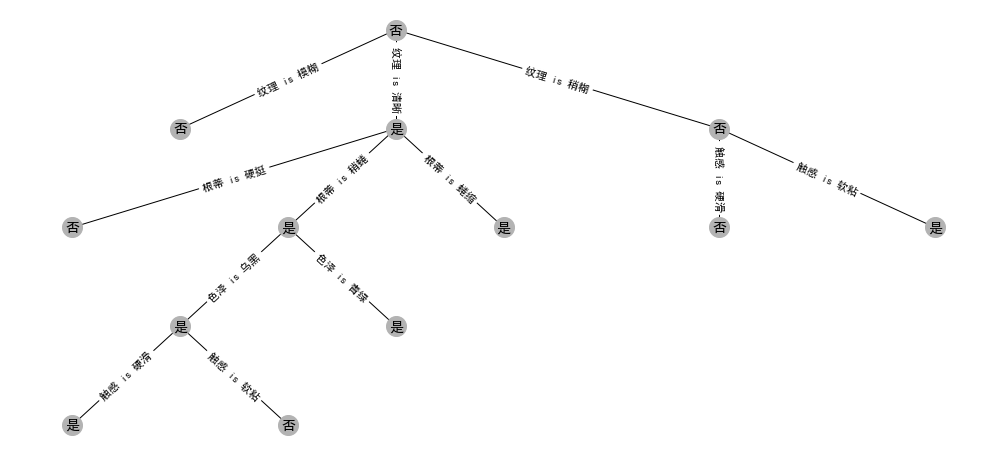

In [10]:
# ID3
tree0 = generate_tree(X, y, scorefunc=gain, maxdepth=None, seed=12)
fg0 = tree_visualize(tree0, colnames)
tree0

In [11]:
classify(X, tree0).ravel(), y.ravel()

(array(['是', '是', '是', '是', '是', '是', '是', '是', '否', '否', '否', '否', '否',
        '否', '否', '否', '否'], dtype='<U1'),
 array(['是', '是', '是', '是', '是', '是', '是', '是', '否', '否', '否', '否', '否',
        '否', '否', '否', '否'], dtype=object))

{None: (3, '否'),
 '模糊': {None: (None, '否')},
 '清晰': {None: (5, '是'),
  '硬滑': {None: (None, '是')},
  '软粘': {None: (2, '否'),
   '浊响': {None: (0, '是'),
    '乌黑': {None: (None, '否')},
    '青绿': {None: (None, '是')}},
   '清脆': {None: (None, '否')}}},
 '稍糊': {None: (5, '否'), '硬滑': {None: (None, '否')}, '软粘': {None: (None, '是')}}}

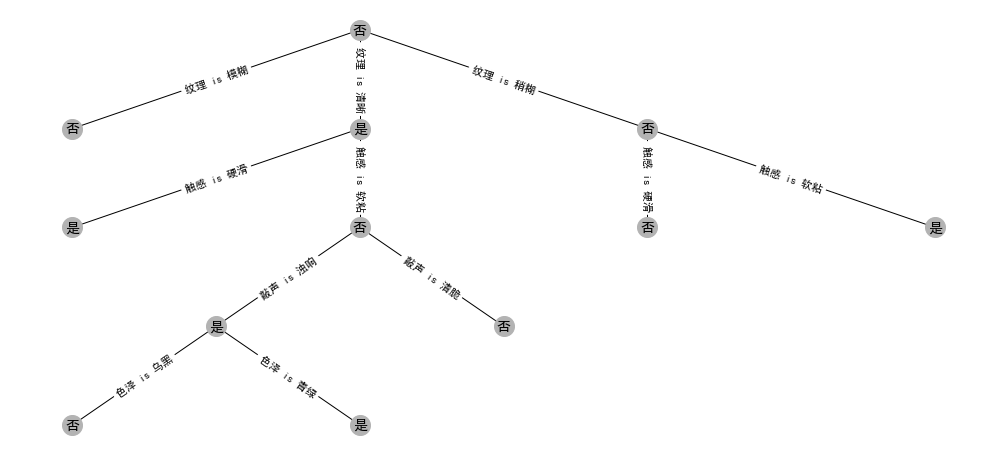

In [12]:
# C4.5
tree1 = generate_tree(X, y, scorefunc=gain_ratio, maxdepth=None, seed=0)
fg1 = tree_visualize(tree1, colnames)
tree1

In [13]:
classify(X, tree1).ravel(), y.ravel()

(array(['是', '是', '是', '是', '是', '是', '是', '是', '否', '否', '否', '否', '否',
        '否', '否', '否', '否'], dtype='<U1'),
 array(['是', '是', '是', '是', '是', '是', '是', '是', '否', '否', '否', '否', '否',
        '否', '否', '否', '否'], dtype=object))

### 决策树的修剪
为了更好的分类训练样本，结点划分会不断进行，造成决策树有过多的分支。当训练数据中存在噪声时，决策树生成算法会过拟合数据。对树的剪枝可以减小模型的复杂度，缓解过拟合，提升决策树的泛化能力。

剪枝(pruning)有两种策略：
1. **预剪枝**：在决策树生成的过程中，在每个结点划分前做评估。当划分不能提升泛化能力时，停止划分并将当前结点标记为叶结点。预剪枝可以减少模型学习时的时间开销，但由于它基于贪心算法，可能在早期就禁止分支展开，从而带来欠拟合的风险。  
2. **后剪枝**：在决策树生成后，从底向上地对非叶结点考察，若将该结点的子树替换为叶结点能提高泛化能力时，将该子树替换为叶结点。后剪枝能保留更多分支，比预剪枝有更好的泛化能力，但消耗时间更多。

为了判断泛化能力是否提升，我们可以用验证集数据计算每一步的精度（西瓜书pp. 80-83）或是损失函数（统计学习方法p. 66）。

In [14]:
# bottom up pruning
def pruning(tree, X_cross, y_cross):
    """
    prune the tree in place
    
    Parameters
    ------------
    tree : dict
        the tree to prune
    X_cross : numpy array, (m', n)
        cross validation data
    y_cross : numpy array, (m', 1)
        cross validation labels
        
    Returns
    --------
    accuracy : double
        accuracy after pruning
    """
    misc = tree[None]
    m = y_cross.shape[0]

    acc_precut = (y_cross==misc[1]).sum()/m
    if misc[0] is None: #leaf
        return acc_precut

    xsplits, Xs_new, ys_new = split_attribute(X_cross, y_cross, misc[0])
    n_correct = 0.
    for xsplit, X_new, y_new in zip(xsplits, Xs_new, ys_new):
        if xsplit in tree:
            n_correct += pruning(tree[xsplit], X_new, y_new)*y_new.shape[0]
        else:
            n_correct += (y_new==misc[1]).sum()
    acc_postcut = n_correct/m
    
    # start to prune
    if acc_postcut < acc_precut:
        for key in list(tree.keys()):
            if key is not None:
                del tree[key]
        return acc_precut
    return acc_postcut

**一个例子**

In [15]:
# split datasets into training and validation, 西瓜书 p. 80
train_index = np.array([1, 2, 3, 6, 7, 10, 14, 15, 16, 17], dtype=int) - 1 # 1-based to 0-based index
cross_index = np.array([4, 5, 8, 9, 11, 12, 13], dtype=int) - 1

X_train, y_train = X[train_index, :], y[train_index, :]
X_cross, y_cross = X[cross_index, :], y[cross_index, :]

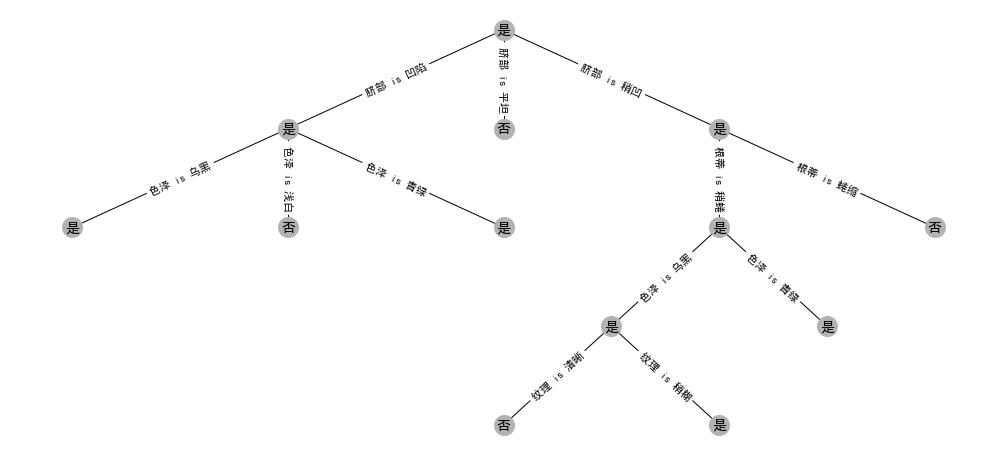

In [16]:
tree2 = generate_tree(X_train, y_train, scorefunc=gain, seed=3) # the tree matches Fig. 4.5
fg2 = tree_visualize(tree2, colnames)

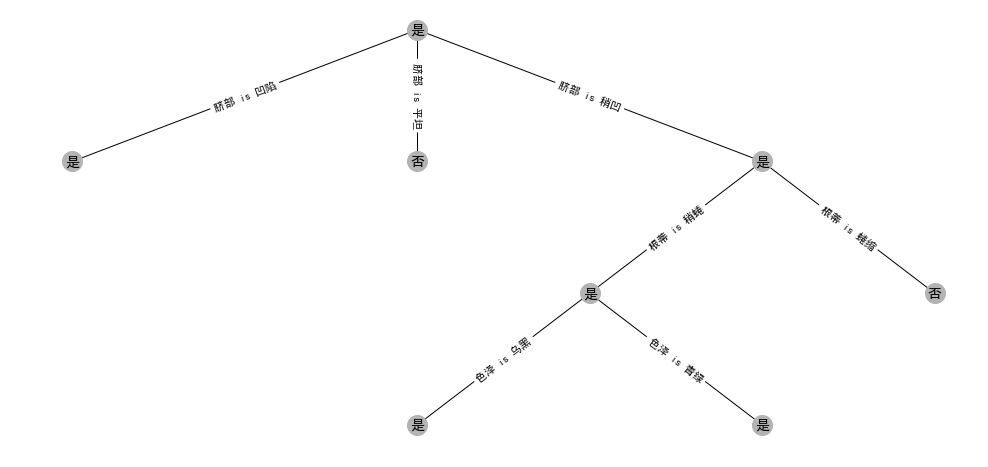

In [17]:
pruning(tree2, X_cross, y_cross)
fg3 = tree_visualize(tree2, colnames)

### 其他的技术细节
#### 连续值特征
利用二分法来处理，即对每个连续特征找一个值`t`用于将某个（如第$i$的分量）特征$X_i$分解为$X_i^-$（其中所有值都$<t$）和$X_i^+$（其中所有值都$\geq t$）。

In [18]:
def find_best_split_point(X, y, attr_axis, scorefunc):
    """
    Parameters
    ------------
    X : numpy array, (m, n)
        features of training examples
    y : numpy array, (m, 1)
        labels of training examples
    attr_axis : integer, [0, n)
        the index of attribute to split
    scorefunc : function, f(y: np.array, ys_new: list) -> float
        the function used to calculate the score of
        each feature

    Returns
    ---------
    x_split : double
        the best split value for the feature
    Xs_new : list of numpy array, [(m1, n), (m-m1, n)]
        the features of splitted examples
    ys_new : list of numpy array, [(m1, 1), (m-m1, 1)]
        the label of splitted examples
    best_score : double
    """
    x = np.unique(X[:, attr_axis]) # sorted
    if len(x) == 1:
        xmids = x
    else:
        xmids = (x[1:]+x[:-1])/2.
    
    best_score = -inf
    best_x_split, best_ys_new = None, None
    for xmid in xmids:
        filter_ = (X[:, attr_axis]<xmid)
        ys_new = [y[filter_, :], y[~filter_, :]]
        score = scorefunc(y, ys_new)
        #print(xmid, score)
        if score > best_score:
            best_score = score
            best_x_split = xmid
            best_ys_new = ys_new
    #print('>>', best_score, best_x_split)

    filter_ = (X[:, attr_axis]<best_x_split)
    best_Xs_new = [X[filter_, :], X[~filter_, :]]
    return best_x_split, best_Xs_new, best_ys_new, best_score

In [19]:
X2 = raw.iloc[:, :-1].values
xsplit, _, _, score = find_best_split_point(X2, y, 6, gain)
xsplit, score # should be 0.381, 0.262

(0.38149999999999995, 0.2624392604045632)

#### 缺失值处理
基本思想是假设缺失值的样本和没有缺失者的分布一致，则可用对应属性上没有缺失值的样本，并加修正系数来估计增益。

给定数据集$D$和属性$a$，设$\tilde D$为属性$a$上没有缺失值的样本，$\tilde D^v$为$\tilde D$中属性$a$取值为$a^v$的样本，$\tilde D_k$为$\tilde D$中类别为$k$的样本。每个样本赋予一个权重$w_x$，它的初始值为1，用于在划分属性未知的样本时把它们平摊到每一类。  
**样本数修正**：$\rho = \sum_{x \in {\tilde D}} w_x / \sum_{x \in D} w_x$，则增益为$Gain(D, a) = \rho \times Gain({\tilde D}, a)$（因为对于$Gain(D, a)$分母上是$D$中样本总数，而$Gain({\tilde D}, a)$分母上是$\tilde D$中样本数）；  
**概率**：用无缺失值样本的经验概率替代，即${\tilde p}_k = \sum_{x \in {\tilde D}_k} w_x /  \sum_{x \in {\tilde D}} w_x$；  
**缺失值样本的划分**：在划分时属性$a$的值未知的样本时，将所有在属性$a$上未知的样本划分到*每个*的子结点中，并调整权重使总权重为1。例如划分到属性值为$a^v$的子结点时，权重修改为$w_x'={\tilde r}_v w_x$，其中${\tilde r}_v = \sum_{x \in {\tilde D}^v} w_x /  \sum_{x \in {\tilde D}} w_x$。

## CART算法
CART假设决策树是二叉树，在每个内部结点处算法对样本使用二分法，如果满足条件则进入左子树，否则进入右子树。  
作为分类决策树，CART算法缓解了ID3, C4.5算法中切分过快的问题。  
同时，由于采用二分法，CART算法也可作为回归算法（回归树）。相比于线性回归，树回归有更高的自由度。

**树回归算法特点**  
优点：可以对复杂和非线性的数据建模。  
缺点：结果不易理解。  
适用数据类型：数值型和标称型数据。

### CART生成
不同于ID4, C4.5这类决策树，CART树在划分特征时并不消耗特征，因为前者已经把所有特征的可能都用完了，而后者未必。

#### 分类决策树
CART分类决策树使用了*最小化*的Gini系数作为最优特征。

In [20]:
def best_feature_CART(X, y, scorefunc, filter_, seed=None):
    """
    Parameters
    ------------
    X : numpy array, (m, n)
        features of training examples
    y : numpy array, (m, 1)
        labels of training examples
    scorefunc : function, f(y: np.array, ys_new: list) -> float
        the function used to calculate the score of
        each feature
    filter_ : array of bools (n, )
        if the corresponding term of feature in filter_ is
        False, the feature will not be splitted
        *NOTE*: make sure not all False in the array
    seed : int or None
        random seed
        
    Returns
    ---------
    best_index : integer, [0, n)
        the index of highest score feature
    best_score : double
        the score of that feature
    best_xsplit : numpy array
        the split point of X for the highest score feature
    best_Xs_new : list of numpy array, [(m1, n), (m2, n), ...]
        the freatures of splitted examples
    best_ys_new : list of numpy array, [(m1, 1), (m2, 1), ...]
        the label of splitted examples
    """
    # generate random indices
    n = X.shape[1]
    indices = np.arange(n)[filter_]
    np.random.seed(seed)
    np.random.shuffle(indices)
    
    # find the best feature
    best_score = -inf
    best_index = None
    best_Xs_new, best_ys_new = None, None
    #print('score:')
    for i in indices:
        # do not split the feature with all the values the same
        if (X[:, i] == X[0, i]).all(): continue

        xsplit, Xs_new, ys_new, score = find_best_split_point(X, y, attr_axis=i, scorefunc=scorefunc)
        #print('    ', i, score)
        if score > best_score:
            best_score = score
            best_index = i
            best_xsplit = xsplit
            best_Xs_new = Xs_new
            best_ys_new = ys_new

    best_xsplit_out = ['<{}'.format(best_xsplit), '>={}'.format(best_xsplit)]
    #print(best_score, best_index, best_xsplit)
    # the best feature can be chosen again in CART
    assert best_index is not None
    return best_index, best_score, best_xsplit_out, best_Xs_new, best_ys_new

def predict_one_CART(x, tree):
    """
    Parameters
    -------------
    x : numpy array, (n, )
        a feature vector for a particular sample
    tree : dict
        the trained tree
        
    Returns
    ---------
    y : object
        the prediction of the input sample
    """
    cur = tree
    while cur[None][0] is not None:
        if len(cur) == 1:
            break
        xval = x[cur[None][0]]
        for k, v in cur.items():
            if k is None:
                continue
            elif k.startswith('<'):
                thres = float(k[1:])
                if xval < thres:
                    cur = cur[k]
                else:
                    cur = cur['>='+k[1:]]
    return cur[None][1]

def predict_CART(X, tree):
    """
    Parameters
    -------------
    X : numpy array, (m, n)
        a feature vector for samples
    tree : dict
        the trained tree
        
    Returns
    ---------
    y : numpy array, (m, 1)
        the prediction of the input samples
    """
    if X.ndim == 1:
        X = X.reshape(1, -1)
    m = X.shape[0]
    y = []
    for i in range(m):
        x = X[i, :]
        y.append(predict_one_CART(x, tree))
    return np.array(y).reshape(-1, 1)

**一个例子**

In [21]:
# do some preprocessings
from sklearn import preprocessing

transformers = {}
X_ = np.zeros_like(X, dtype=int)
for i in range(X.shape[1]):
    le = preprocessing.LabelEncoder()
    X_[:, i] = le.fit_transform(X[:, i])
    transformers['X{}'.format(i)] = le

le = preprocessing.LabelEncoder()
y_ = le.fit_transform(y).reshape(-1, 1)
transformers['y'] = le

X_, y_.ravel()

/home/szqtc/Softwares/Anaconda/INSTALLED/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(array([[2, 2, 1, 1, 0, 0],
        [0, 2, 0, 1, 0, 0],
        [0, 2, 1, 1, 0, 0],
        [2, 2, 0, 1, 0, 0],
        [1, 2, 1, 1, 0, 0],
        [2, 1, 1, 1, 2, 1],
        [0, 1, 1, 2, 2, 1],
        [0, 1, 1, 1, 2, 0],
        [0, 1, 0, 2, 2, 0],
        [2, 0, 2, 1, 1, 1],
        [1, 0, 2, 0, 1, 0],
        [1, 2, 1, 0, 1, 1],
        [2, 1, 1, 2, 0, 0],
        [1, 1, 0, 2, 0, 0],
        [0, 1, 1, 1, 2, 1],
        [1, 2, 1, 0, 1, 0],
        [2, 2, 0, 2, 2, 0]]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

{None: (3, 0),
 '<0.5': {None: (None, 0)},
 '>=0.5': {None: (3, 1),
  '<1.5': {None: (5, 1),
   '<0.5': {None: (None, 1)},
   '>=0.5': {None: (0, 0),
    '<1.0': {None: (None, 0)},
    '>=1.0': {None: (2, 1),
     '<1.5': {None: (None, 1)},
     '>=1.5': {None: (None, 0)}}}},
  '>=1.5': {None: (5, 0),
   '<0.5': {None: (None, 0)},
   '>=0.5': {None: (None, 1)}}}}

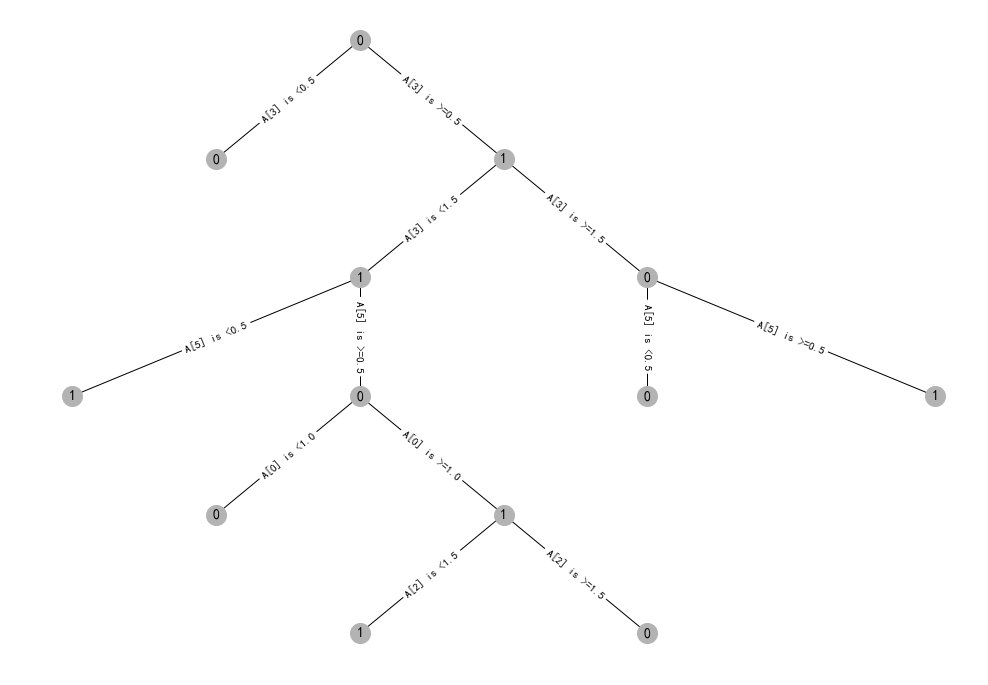

In [22]:
# CART classification tree
tree3 = generate_tree(X_, y_, neg_gini_index, seed=4, feature_finder=best_feature_CART)
fg4 = tree_visualize(tree3, figsize=(17, 12))
tree3

In [23]:
predict_CART(X_, tree3).ravel(), y_.ravel()

(array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

#### 回归树
回归树模型将输入空间划分成多个超立方体，每个立方体中取相同的值。假设输入空间被划分为$\{R_1, R_2, \cdots, R_M\}$，每个单元$R_m$上的输出值为$c_m$，则回归树模型为$f(x) = \sum_{m=1}^M c_m 1(x \in R_m)$。为了最小化模型与数据的平方误差，${\hat c}_m=\sum_{x_i \in R_m} y_i/N_m$，即$R_m$中样本标记的平均。

在回归树中，最优的特征和划分值是通过*最小化*平方误差（注意不要做样本平均，因为划分要尽量在样本多处进行）得到的：
$\min_{j, t} \left [ \sum_{x_i \in \{x| x[j]<t\}\cap D} (y_i - {\hat c}_1)^2 + \sum_{x_i \in \{x| x[j] \geq t\}\cap D} (y_i - {\hat c}_2)^2  \right ]$，其中，${\hat c}_1 = \sum_{x_i \in \{x| x[j]<t\}\cap D} y_i / N_1$，${\hat c}_2 = \sum_{x_i \in \{x| x[j] \geq t\}\cap D} y_i / N_2$

In [24]:
def neg_square_error(y_before, ys_after):
    """
    Parameters
    ------------
    y_before : numpy array, (m, 1)
        the labels before splitted
        *NOTE*: THIS PARAMETER IS REDUNDANT, WHICH
                      AIMS TO KEEP THE API CONSISTENT
    ys_after : list of numpy array, [(m1, 1), (m2, 1), ...], m1+m2+...=m
        the list of labels splitted
    
    Returns
    ---------
    neg_square_error : scalar
        negative of the sum of square error for each component in ys_after
    """
    sqerr = 0.
    for y in ys_after:
        ymean = y.mean()
        sqerr += ((y-ymean)**2).sum()
    return -sqerr

def generate_regression_tree(X, y, scorefunc,
                 maxdepth=None, filter_=None, seed=None):
    """
    The main structure of generate a decision tree:
    1. if same type labels of features, set to be a leaf node
    2. find the best feature to separate, set to be a inner node
    3. separate the training data with the feature, deal
        with each of them recursively
    
    Parameters
    ------------
    X : numpy array, (m, n)
        features of training examples
    y : numpy array, (m, 1)
        labels of training examples
    scorefunc : function, f(y: np.array, ys_new: list) -> float
        the function used to calculate the score of
        each feature
    maxdepth : integer, or None (default)
        the maximum depth of the tree
    filter_ : array of bools (n, ), or None (default)
        if the corresponding term of feature in filter_ is
        False, the feature will not be splitted
    seed : int or None
        random seed
        
    Returns
    ---------
    tree : dict
        {cond1 : subtree1, cond2 : subtree2, ...} for tree:
                       root
            cond1 /     \ cond2
                     /         \
           subtree1    subtree2
    """
    #print(X, y, maxdepth, filter_, seed)
    # create a new node
    tree = {}

    m, n = X.shape
    if filter_ is None:
        filter_ = np.array([True]*n, dtype=bool)

    # default case: the average y value (different here)
    ydef = y.mean()
    tree[None] = (None, ydef) # axis, label
        
    # case 0: all the case with the same label
    if (y[:, 0] == y[0,0]).all():
        #print('c0')
        return tree
    
    # case 1: reach the maxdepth
    if maxdepth is not None and maxdepth <= 1:
        #print('c1')
        return tree
    
    # case 2: no attribute remains
    if not filter_.any():
        #print('c2')
        return tree
    
    # case 3: all the features are the same
    i = 0
    while i<n and (not filter_[i] or (X[:, i]==X[0, i]).all()):
        i += 1
    if i == n:
        #print('c3')
        return tree

    # find the best feature (different here)
    best_index, best_score, best_xsplit, best_Xs_new, best_ys_new = \
        best_feature_CART(X, y, scorefunc, filter_=filter_, seed=seed)
    
    # recursively generate the trees
    tree[None] = (best_index, ydef) # axis, label
    for xsplit, X_new, y_new in zip(best_xsplit, best_Xs_new, best_ys_new):
        child = generate_regression_tree(
            X_new, y_new, scorefunc,
            maxdepth=maxdepth if maxdepth is None else maxdepth-1,
            filter_=filter_.copy(), seed=seed if seed is None else seed+1
        )
        tree[xsplit] = child
    return tree

**一个例子**

In [25]:
#! head datasets/MLiA/Ch09/ex0.txt

In [26]:
raw2 = np.loadtxt('datasets/MLiA/Ch09/ex0.txt')
X3, y3 = raw2[:, 1:-1], raw2[:, -1:]

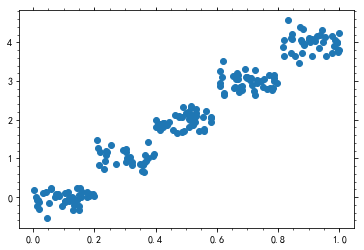

In [27]:
fg5, ax5 = plt.subplots()
ax5.plot(X3[:, 0], y3[:, 0], ls='None', marker='o', c='C0', label='obs')

{None: (0, 2.00369868),
 '<0.397254': {None: (0, 0.39728045333333334),
  '<0.20301550000000002': {None: (0, -0.023838155555555553),
   '<0.14998250000000002': {None: (0, -0.054810500000000005),
    '<0.1458915': {None: (None, -0.040866062499999994)},
    '>=0.1458915': {None: (None, -0.2779215)}},
   '>=0.14998250000000002': {None: (0, 0.07189454545454545),
    '<0.176305': {None: (None, 0.10609520000000001)},
    '>=0.176305': {None: (None, 0.043393999999999995)}}},
  '>=0.20301550000000002': {None: (0, 1.0289583666666666),
   '<0.212827': {None: (0, 1.3753635000000002),
    '<0.2093695': {None: (None, 1.487788)},
    '>=0.2093695': {None: (None, 1.262939)}},
   '>=0.212827': {None: (0, 1.0042151428571429),
    '<0.37533249999999996': {None: (None, 0.9802326799999999)},
    '>=0.37533249999999996': {None: (None, 1.204069)}}}},
 '>=0.397254': {None: (0, 2.9675496160000003),
  '<0.5957425000000001': {None: (0, 1.980035071428571),
   '<0.48716800000000005': {None: (0, 1.8810897500000001)

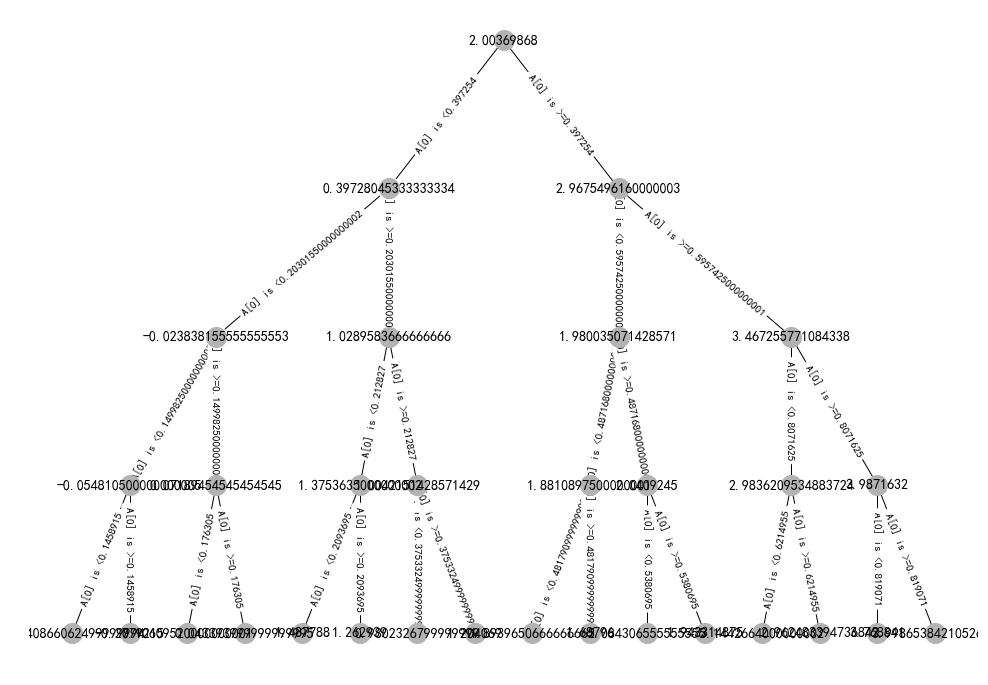

In [28]:
# CART regression tree
tree4 = generate_regression_tree(X3, y3, neg_square_error, seed=4, maxdepth=5)
fg6 = tree_visualize(tree4, figsize=(17, 12))
tree4

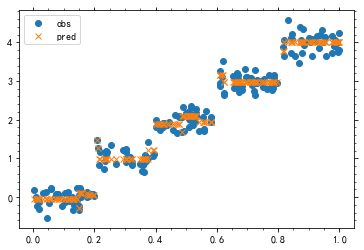

In [29]:
y3_pred = predict_CART(X3, tree4)
ax5.plot(X3[:, 0], y3_pred[:, 0], ls='None', marker='x', c='C1', label='pred')
ax5.legend()
fg5

### scikit-learn
`sklearn`的`tree`模块只实现了CART决策树，详见[tree模块的文档](http://scikit-learn.org/stable/modules/tree.html#mathematical-formulation)。
其中，`DecisionTreeClassifier`实现分类决策树，`DecisionTreeRegressor`实现回归树的功能。

`sklearn`中不包含剪枝的功能，只能通过设定最大树高、最小分类样本数来避免过拟合。

#### Tips on practical use
- 特征数多的模型需要更多数据：Decision trees tend to overfit on data with a large number of features. Getting the right ratio of samples to number of features is important, since a tree with few samples in high dimensional space is very likely to overfit.
- 使用降维算法：Consider performing dimensionality reduction (PCA, ICA, or Feature selection) beforehand to give your tree a better chance of finding features that are discriminative.
- 逐渐增加树的高度，并多做图看看：Visualise your tree as you are training by using the `export` function. Use `max_depth=3` as an initial tree depth to get a feel for how the tree is fitting to your data, and then increase the depth.
- 限制树高防止过拟合：Remember that the number of samples required to populate the tree doubles for each additional level the tree grows to. Use `max_depth` to control the size of the tree to prevent overfitting.
- 限制`min_samples_split`或`min_samples_leaf`来防止过拟合：Use `min_samples_split` or `min_samples_leaf` to control the number of samples at a leaf node. A very small number will usually mean the tree will overfit, whereas a large number will prevent the tree from learning the data. Try `min_samples_leaf=5` as an initial value. If the sample size varies greatly, a float number can be used as percentage in these two parameters. *The main difference between the two is that `min_samples_leaf `guarantees a minimum number of samples in a leaf, while `min_samples_split` can create arbitrary small leaves, though `min_samples_split` is more common in the literature*.
- 正负类样本数目要相近，防止在多数投票时bias到数目多的类型中去：Balance your dataset before training to prevent the tree from being biased toward the classes that are dominant. Class balancing can be done by sampling an equal number of samples from each class, or preferably by normalizing the sum of the sample weights (`sample_weight`) for each class to the same value. Also note that weight-based pre-pruning criteria, such as `min_weight_fraction_leaf`, will then be less biased toward dominant classes than criteria that are not aware of the sample weights, like min_samples_leaf.
- 加权样本：If the samples are weighted, it will be easier to optimize the tree structure using weight-based pre-pruning criterion such as `min_weight_fraction_leaf`, which ensure that leaf nodes contain at least a fraction of the overall sum of the sample weights.
- 训练样本均会改成单精度类型：All decision trees use `np.float32` arrays internally. If training data is not in this format, a copy of the dataset will be made.
- 稀疏的数据用稀疏矩阵：If the input matrix X is very sparse, it is recommended to convert to sparse `csc_matrix` before calling fit and sparse `csr_matrix` before calling predict. Training time can be orders of magnitude faster for a sparse matrix input compared to a dense matrix when features have zero values in most of the samples.

In [30]:
# CART classification tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_, y_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

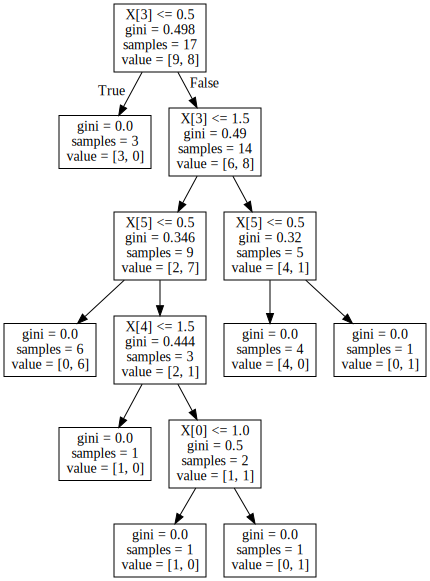

In [31]:
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph

In [32]:
clf.predict(X_), y_.ravel()

(array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [33]:
# CART regression tree
reg = tree.DecisionTreeRegressor(max_depth=5)
reg.fit(X3, y3)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

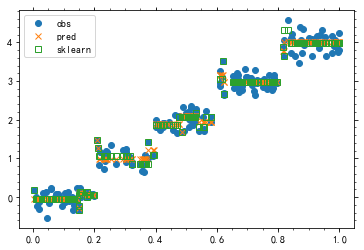

In [34]:
y3_pred2 = reg.predict(X3)
ax5.plot(X3[:, 0], y3_pred2[:], ls='None', marker='s', mfc='None', c='C2', label='sklearn')
ax5.legend()
fg5